# anomaly_detection.ipynb

#### A code to use the anomaly detection strategy to train the thresholds for the variability parameters eta and V

#### Import all the dependencies and generic setup

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['legend.loc'] = 'best'
from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties
import os
import glob
import numpy as np
import pandas as pd
from scipy import optimize
import tkp.db
import logging
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING
import sqlalchemy
from sqlalchemy import *
from sqlalchemy.orm import relationship
import sys
sys.path.append('../')
from dblogin import * # This file contains all the variables required to connect to the database
from database_tools import dbtools
from tools import tools
from plotting import plot_varib_params as pltvp
from machine_learning import train_anomaly_detect
from machine_learning import generic_tools

/home/antoniar/JupyterEnv/local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


#### The input data and thresholds

In [2]:
tests = False
plots = False
precis_thresh = 0.99
recall_thresh = 0.95
path='ml_csv_files/'
stableData = path+'stable_sources.csv'
simulatedData = path+'sim_*_trans_data.csv'

#### Load the data and give appropriate labels

In [3]:
all_data = generic_tools.load_data(stableData,simulatedData)

#### Load the simulations and only keep those with a full lightcurve and with variability parameters > 0

In [4]:
all_data=all_data.loc[(all_data['ttype'] == 2) & (all_data['V']>0.) & (all_data['eta']>0.)]

#### put the training data into the format required for the training 

In [5]:
train_data = all_data.apply(lambda row:[np.log10(row['eta']),np.log10(row['V']),row['variable'],row['label']],axis=1)
train_data = train_data.as_matrix()

#### Obtain the training data if it doesn't already exist on disk (SLOW!)

In [6]:
if not os.path.exists('ml_csv_files/sigma_data.txt'):
    filename = open("ml_csv_files/sigma_data.txt", "w")
    filename.write('')
    filename.close()
    train_anomaly_detect.multiple_trials(train_data,path+"sigma_data.txt")
data2=np.genfromtxt(path+'sigma_data.txt', delimiter=' ')

#### Using the training data, find the sigma threshold combination that best fits input thresholds

In [7]:
best_sigma1, best_sigma2 = train_anomaly_detect.find_best_sigmas(precis_thresh,recall_thresh,data2,tests,train_data,plots,path)
print 'sigma_(eta_nu)='+str(best_sigma1)+', sigma_(V_nu)='+str(best_sigma2) 

Best sigmas found:3.43693693694, 1.48548548549
sigma_(eta_nu)=3.43693693694, sigma_(V_nu)=1.48548548549


#### Find the eta and V thresholds for the data

In [8]:
sigcutx,paramx,range_x = generic_tools.get_sigcut([a[0] for a in train_data if a[2]==0.],best_sigma1)
sigcuty,paramy,range_y = generic_tools.get_sigcut([a[1] for a in train_data if a[2]==0.],best_sigma2)
print(r'Gaussian Fit $\eta$: '+str(round(10.**paramx[0],2))+'(+'+str(round((10.**(paramx[0]+paramx[1])-10.**paramx[0]),2))+' '+str(round((10.**(paramx[0]-paramx[1])-10.**paramx[0]),2))+')')
print(r'Gaussian Fit $V$: '+str(round(10.**paramy[0],2))+'(+'+str(round((10.**(paramy[0]+paramy[1])-10.**paramy[0]),2))+' '+str(round((10.**(paramy[0]-paramy[1])-10.**paramy[0]),2))+')')
print 'Eta_nu threshold='+str(10.**sigcutx)+', V_nu threshold='+str(10.**sigcuty)

threshx=10.**sigcutx
threshy=10.**sigcuty

Gaussian Fit $\eta$: 0.29(+0.86 -0.22)
Gaussian Fit $V$: 0.07(+0.09 -0.04)
Eta_nu threshold=31.7365329545, V_nu threshold=0.234867845544


#### Calculate the false positives (FP), true negatives (TN), true positives (TP) and false negatives (FN)

In [9]:
all_data.loc[(((all_data['eta']<threshx) | (all_data['V']<threshy)) & (all_data['variable'] == 1)),'classified'] = 'FN'
all_data.loc[((all_data['eta']>=threshx) & (all_data['V']>=threshy) & (all_data['variable'] == 1)),'classified'] = 'TP'
all_data.loc[(((all_data['eta']<threshx) | (all_data['V']<threshy)) & (all_data['variable'] == 0)),'classified'] = 'TN'
all_data.loc[((all_data['eta']>=threshx) & (all_data['V']>=threshy) & (all_data['variable'] == 0)),'classified'] = 'FP'

#### Find candidates
As we assumed all the real data were stable sources, the candidate variables are those classified as FP

In [10]:
all_data.loc[(all_data['classified'] == 'FP')]

,#Runcat,Dec,RA,V,detectionThreshold,detectionThreshold,dpts,eta,flux,fluxrat,freq,label,maxRmsSigma,minRmsSigma,ttype,variable,classified
2380,12670,49.754788,148.187863,0.486695,0.0,NaN,8,58.269373,0.963594,1.344145,185,stable,0.0,0.0,2,0,FP
15701,12670,49.754788,148.187863,0.354798,0.0,NaN,24,37.396377,1.683226,1.720861,124,stable,0.0,0.0,2,0,FP
18458,8442,55.525465,227.355440,0.275502,0.0,NaN,24,35.359386,1.420681,1.320655,124,stable,0.0,0.0,2,0,FP


#### Calculate the precision and recall

In [11]:
precision, recall =  generic_tools.precision_and_recall(len(all_data.loc[(all_data['classified'] == 'TP')]),len(all_data.loc[(all_data['classified'] == 'FP')]),len(all_data.loc[(all_data['classified'] == 'FN')]))

In [12]:
print "Precision: "+str(precision)+", Recall: "+str(recall)

Precision: 0.989690721649, Recall: 0.9


#### Create eta V plot showing training results

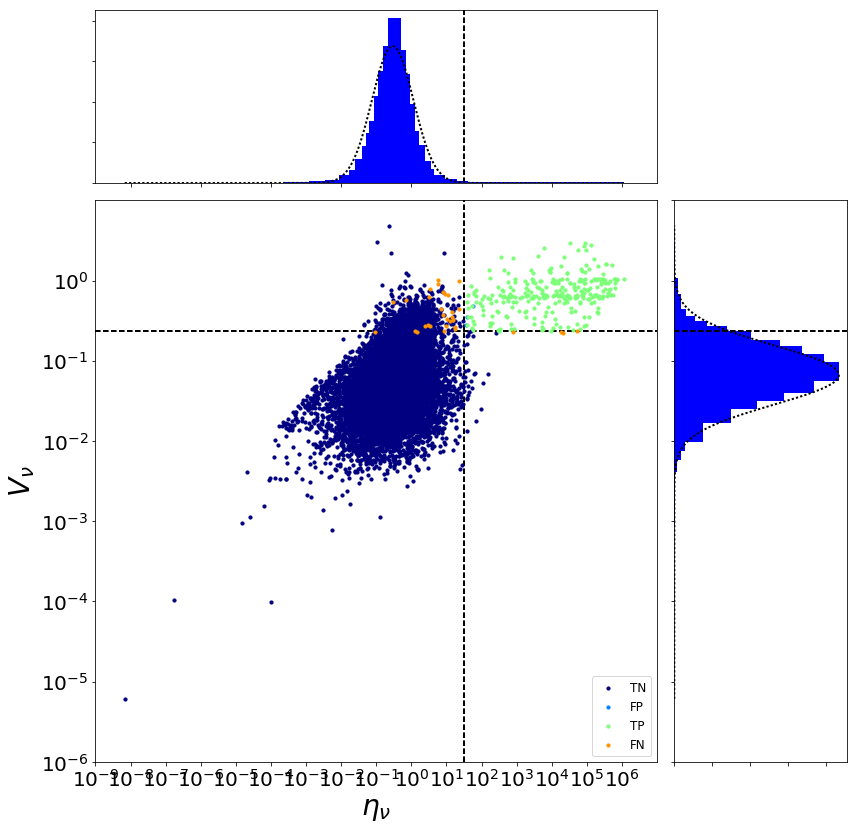

In [13]:
plotdata=all_data
frequencies=plotdata.classified.unique()
col = pltvp.make_cmap(frequencies)

nullfmt   = NullFormatter()         # no labels
fontP = FontProperties()
fontP.set_size('large')
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
fig = plt.figure(1,figsize=(12,12))
axScatter = fig.add_subplot(223, position=rect_scatter)
plt.xlabel(r'$\eta_{\nu}$', fontsize=28)
plt.ylabel(r'$V_{\nu}$', fontsize=28)
axHistx=fig.add_subplot(221, position=rect_histx)
axHisty=fig.add_subplot(224, position=rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.axes.yaxis.set_ticklabels([])
axHisty.axes.xaxis.set_ticklabels([])

for i in range(len(frequencies)):
    plotdataTMP=plotdata.loc[(plotdata['classified']==frequencies[i])]
    xdata_var=np.log10(plotdataTMP['eta'])
    ydata_var=np.log10(plotdataTMP['V'])
    axScatter.scatter(xdata_var, ydata_var,color=col[i], s=10., zorder=5)

x = np.log10(plotdata['eta'])
y = np.log10(plotdata['V'])

axHistx.hist(x, bins=pltvp.make_bins(x), normed=1, histtype='stepfilled', color='b')
axHisty.hist(y, bins=pltvp.make_bins(y), normed=1, histtype='stepfilled', orientation='horizontal', color='b')

freq_labels=[f for f in frequencies]
axScatter.legend(freq_labels,loc=4, prop=fontP)
xmin=int(min(x)-1.1)
xmax=int(max(x)+1.1)
ymin=int(min(y)-1.1)
ymax=int(max(y)+1.1)
xvals=range(xmin,xmax)
xtxts=[r'$10^{'+str(a)+'}$' for a in xvals]
yvals=range(ymin,ymax)
ytxts=[r'$10^{'+str(a)+'}$' for a in yvals]
axScatter.set_xlim([xmin,xmax])
axScatter.set_ylim([ymin,ymax])
axScatter.set_xticks(xvals)
axScatter.set_xticklabels(xtxts, fontsize=20)
axScatter.set_yticks(yvals)
axScatter.set_yticklabels(ytxts, fontsize=20)
axHistx.set_xlim( axScatter.get_xlim())
axHisty.set_ylim( axScatter.get_ylim())

if sigcutx != 0 or sigcuty != 0:
    axHistx.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')
    axHisty.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
    axScatter.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
    axScatter.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')

range_x,fitx = pltvp.gaussian_fit(x,paramx)
axHistx.plot(range_x,fitx, 'k:', linewidth=2)
range_y,fity = pltvp.gaussian_fit(y,paramy)
axHisty.plot(fity,range_y, 'k:', linewidth=2)



#### Create the diagnostic plot

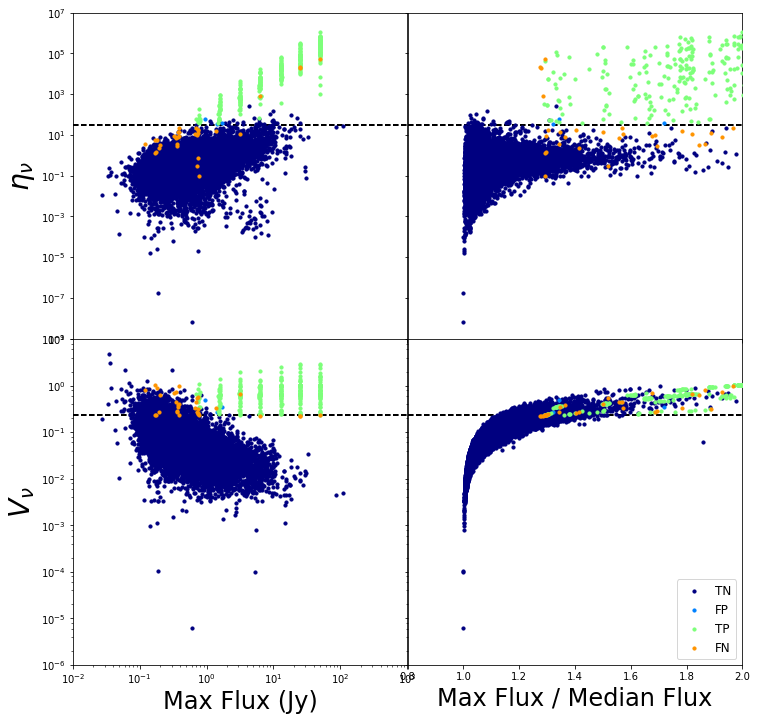

In [14]:
fig = plt.figure(1,figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fontP = FontProperties()
fontP.set_size('large')
fig.subplots_adjust(hspace = .001, wspace = 0.001)
ax1.set_ylabel(r'$\eta_\nu$', fontsize=28)
ax3.set_ylabel(r'$V_\nu$', fontsize=28)
ax3.set_xlabel('Max Flux (Jy)', fontsize=24)
ax4.set_xlabel('Max Flux / Median Flux', fontsize=24)

for i in range(len(frequencies)):
    plotdataTMP=plotdata.loc[(plotdata['classified']==frequencies[i])]
    xdata_ax3=plotdataTMP['flux']
    xdata_ax4=plotdataTMP['fluxrat']
    ydata_ax1=plotdataTMP['eta']
    ydata_ax3=plotdataTMP['V']
    ax1.scatter(xdata_ax3, ydata_ax1,color=col[i], s=10., zorder=5)
    ax2.scatter(xdata_ax4, ydata_ax1,color=col[i], s=10., zorder=6)
    ax3.scatter(xdata_ax3, ydata_ax3,color=col[i], s=10., zorder=7)
    ax4.scatter(xdata_ax4, ydata_ax3,color=col[i], s=10., zorder=8)
    ax4.legend(freq_labels, loc=4, prop=fontP)

Xax3=plotdata['flux']
Xax4=plotdata['fluxrat']
Yax1=plotdata['eta']
Yax3=plotdata['V']
    
if sigcutx != 0 or sigcuty != 0:
    ax1.axhline(y=10.**sigcutx, linewidth=2, color='k', linestyle='--')
    ax2.axhline(y=10.**sigcutx, linewidth=2, color='k', linestyle='--')
    ax3.axhline(y=10.**sigcuty, linewidth=2, color='k', linestyle='--')
    ax4.axhline(y=10.**sigcuty, linewidth=2, color='k', linestyle='--')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax4.set_yscale('log')
xmin_ax3=10.**(int(np.log10(min(Xax3))-1.1))
xmax_ax3=10.**(int(np.log10(max(Xax3))+1.2))
xmin_ax4=0.8
xmax_ax4=int(max(xdata_ax4)+0.5)
ymin_ax1=10.**(int(np.log10(min(Yax1))-1.1))
ymax_ax1=10.**(int(np.log10(max(Yax1))+1.2))
ymin_ax3=10.**(int(np.log10(min(Yax3))-1.1))
ymax_ax3=10.**(int(np.log10(max(Yax3))+1.2))
ax1.set_ylim(ymin_ax1,ymax_ax1)
ax3.set_ylim(ymin_ax3,ymax_ax3)
ax3.set_xlim(xmin_ax3,xmax_ax3)
ax4.set_xlim(xmin_ax4,xmax_ax4)
ax1.set_xlim( ax3.get_xlim() )
ax4.set_ylim( ax3.get_ylim() )
ax2.set_xlim( ax4.get_xlim() )
ax2.set_ylim( ax1.get_ylim() )
ax1.xaxis.set_major_formatter(nullfmt)
ax4.yaxis.set_major_formatter(nullfmt)
ax2.xaxis.set_major_formatter(nullfmt)
ax2.yaxis.set_major_formatter(nullfmt)